In [ ]:
# This Jupyter notebook walks you through scraping LinkedIn posts from Ernest & Young (EY) using Selenium in Python. 
# We'll scroll the page, extract post text and timestamps, and analyze for sustainability mentions.


In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
# Launch Chrome and Navigate to LinkedIn
chrome_options = Options()
# Comment this out if you want to see the browser
# chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--window-size=1280,800')

service = Service()  # Use default path if chromedriver is in PATH
driver = webdriver.Chrome(service=service, options=chrome_options)

# Navigate to EY's LinkedIn posts page
driver.get("https://www.linkedin.com/company/ernstandyoung/posts/?feedView=all")

# Pause to log in manually
input("⏸ Please log in to LinkedIn in the opened browser, then press [Enter] to continue...")


⏸ Please log in to LinkedIn in the opened browser, then press [Enter] to continue... 


''

In [3]:
#testing the scraper 
SCROLL_PAUSE_TIME = 1  # seconds between scrolls
SCROLL_COUNT = 600  # adjust as needed

for i in range(600):  # start small for testing
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    print(f"✅ Scroll {i + 1} of {SCROLL_COUNT} complete")

print("Done scrolling.")

✅ Scroll 1 of 600 complete
✅ Scroll 2 of 600 complete
✅ Scroll 3 of 600 complete
✅ Scroll 4 of 600 complete
✅ Scroll 5 of 600 complete
✅ Scroll 6 of 600 complete
✅ Scroll 7 of 600 complete
✅ Scroll 8 of 600 complete
✅ Scroll 9 of 600 complete
✅ Scroll 10 of 600 complete
✅ Scroll 11 of 600 complete
✅ Scroll 12 of 600 complete
✅ Scroll 13 of 600 complete
✅ Scroll 14 of 600 complete
✅ Scroll 15 of 600 complete
✅ Scroll 16 of 600 complete
✅ Scroll 17 of 600 complete
✅ Scroll 18 of 600 complete
✅ Scroll 19 of 600 complete
✅ Scroll 20 of 600 complete
✅ Scroll 21 of 600 complete
✅ Scroll 22 of 600 complete
✅ Scroll 23 of 600 complete
✅ Scroll 24 of 600 complete
✅ Scroll 25 of 600 complete
✅ Scroll 26 of 600 complete
✅ Scroll 27 of 600 complete
✅ Scroll 28 of 600 complete
✅ Scroll 29 of 600 complete
✅ Scroll 30 of 600 complete
✅ Scroll 31 of 600 complete
✅ Scroll 32 of 600 complete
✅ Scroll 33 of 600 complete
✅ Scroll 34 of 600 complete
✅ Scroll 35 of 600 complete
✅ Scroll 36 of 600 complete
✅

In [5]:
#extract posts 

from selenium.webdriver.common.by import By
import pandas as pd

# Find all post containers
post_containers = driver.find_elements(By.CLASS_NAME, "feed-shared-update-v2")

post_texts = []
post_timestamps = []

for post in post_containers:
    try:
        # Post text
        text_elem = post.find_element(By.CLASS_NAME, "update-components-text")
        post_text = text_elem.text.strip()
    except:
        post_text = ""
        
#clean up timestamps
from selenium.webdriver.common.by import By
import re

post_texts = []
post_timestamps = []

for post in post_containers:
    # Extract post text
    try:
        text_elem = post.find_element(By.CLASS_NAME, "update-components-text")
        post_text = text_elem.text.strip()
    except:
        post_text = ""

    # Extract timestamp from the correct sub-description span
    try:
        sub_desc = post.find_element(By.CLASS_NAME, "update-components-actor__sub-description")
        time_span = sub_desc.find_element(By.XPATH, './/span[@aria-hidden="true"]')
        timestamp_raw = time_span.text.strip()
        match = re.search(r'\d+[a-z]+', timestamp_raw)  # e.g., "2mo", "1y"
        post_timestamp = match.group(0) if match else timestamp_raw
    except:
        post_timestamp = ""

    post_texts.append(post_text)
    post_timestamps.append(post_timestamp)

# Create DataFrame
df = pd.DataFrame({
    "timestamp": post_timestamps,
    "post": post_texts
})

# Preview
df.head()


,timestamp,post
0,8h,The US IPO market gained momentum with a stron...
1,13h,NEWS: EY has appointed Bridget Walsh to the fi...
2,4d,Nearly 60% of the FTSE 100’s gains over the pa...
3,1w,21% of senior leaders already invest $10M+ in ...
4,1w,"CIOs, CTOs, and CDOs are at a crossroads.\n \n..."


In [6]:
#export to CSV 
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    "timestamp": post_timestamps,
    "post": post_texts
})

# Save to CSV
df.to_csv("ey_linkedin_posts.csv", index=False, encoding="utf-8")

print("Export complete: ey_linkedin_posts.csv")

Export complete: ey_linkedin_posts.csv


In [7]:
pd.read_csv("ey_linkedin_posts.csv")

,timestamp,post
0,8h,The US IPO market gained momentum with a stron...
1,13h,NEWS: EY has appointed Bridget Walsh to the fi...
2,4d,Nearly 60% of the FTSE 100’s gains over the pa...
3,1w,21% of senior leaders already invest $10M+ in ...
4,1w,"CIOs, CTOs, and CDOs are at a crossroads.\n \n..."
...,...,...
281,11mo,Congratulations to the EY recipients of the As...
282,11mo,Happy \nhashtag\n#InternationalDogDay! Drop a ...
283,11mo,We’re proud to once again be named one of the ...
284,11mo,We're committed to fostering an inclusive and ...


In [8]:
#translate the timestamps into actual dates 

from datetime import datetime, timedelta

def normalize_timestamp(rel_time):
    today = datetime.today()

    if pd.isna(rel_time) or not isinstance(rel_time, str):
        return None

    rel_time = rel_time.strip().replace(" ", "")
    
    match = re.match(r"(\d+)([a-zA-Z]+)", rel_time)
    if not match:
        return None

    value, unit = int(match.group(1)), match.group(2).lower()

    if unit.startswith("h"):       # hours ago → today
        return today.date()
    elif unit.startswith("d"):     # days
        return (today - timedelta(days=value)).date()
    elif unit.startswith("w"):     # weeks
        return (today - timedelta(weeks=value)).date()
    elif unit.startswith("mo"):    # months (approximate)
        return (today - timedelta(days=30 * value)).date()
    elif unit.startswith("y"):     # years (approximate)
        return (today - timedelta(days=365 * value)).date()
    else:
        return None

# Apply to DataFrame
df["normalized_date"] = df["timestamp"].apply(normalize_timestamp)

# Preview results
df[["timestamp", "normalized_date"]].head()


,timestamp,normalized_date
0,8h,2025-08-06
1,13h,2025-08-06
2,4d,2025-08-02
3,1w,2025-07-30
4,1w,2025-07-30


In [13]:
# setting up classification 
from openai import OpenAI
from IPython.display import display, Markdown
from tqdm.auto import tqdm
tqdm.pandas()

from dotenv import load_dotenv

In [14]:
df = pd.read_csv("ey_linkedin_posts.csv")
df.dropna(subset=["post"], inplace=True)

In [15]:
#sample the data 
SIZE_OF_SAMPLE = min(50, len(df))  # ensures we don't sample more than we have
text_column_name = "post"

data_full = df.copy()
data_sample = data_full.sample(n=SIZE_OF_SAMPLE, random_state=42)

In [16]:
import os
from dotenv import load_dotenv

# Point to your .env file
load_dotenv(dotenv_path="/Users/klararehm/Desktop/final_project/.env")

# Retrieve API key securely
api_key = os.getenv("OPENAI_API_KEY")

# Confirm the API key has loaded 
print("✅ API key loaded." if api_key else "❌ API key not found.")

✅ API key loaded.


In [17]:
client = OpenAI(api_key=api_key)

In [19]:
from enum import Enum
from pydantic import BaseModel
from tqdm.auto import tqdm
tqdm.pandas()

# Define classification categories
class PostCategory(str, Enum):
    sustainability = "Sustainability / Green Growth / Climate"
    esg_social = "ESG – including DEI (Diversity, Equity & Inclusion)"
    ai_tech = "AI / Technology / Innovation"
    strategy = "Corporate Strategy / Business Management"
    geopolitics = "Geopolitics / International Affairs"
    hr = "HR / Talent / Culture & Inclusion"
    other = "Other"

# Prompt template
prompt_base = """
You are an expert social media analyst. Please categorize the following LinkedIn post into one of these categories to the best of your ability: {categories}

Post:
{text}
"""

categories = ", ".join([f'"{cat.value}"' for cat in PostCategory])
sample_prompts = data_sample.apply(lambda row: prompt_base.format(text=row["post"], categories=categories), axis=1)

# Format prompts
data_sample_prompt_column = data_sample.progress_apply(lambda row: prompt_base.format(
    text=row["post"],
    categories=", ".join([f'"{opt.value}"' for opt in PostCategory])
), axis=1)

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
#counting tokens for cost estimate 

import tiktoken

def count_tokens(model, text):
    encoding = tiktoken.encoding_for_model(model if model != 'gpt-4.1-mini' else 'gpt-4o')
    tokens = encoding.encode(text)
    return len(tokens)

input_token_costs = {
    "gpt-4.1-mini": 0.4 / 1_000_000,
    "mistral-medium-latest": 0.4 / 1_000_000,
    "mistral-large-latest": 2.0 / 1_000_000
}

def estimate_cost(model, token_count):
    return token_count * input_token_costs[model]

In [21]:
#determine OpenAI model to use and cost estimation helper 
MODEL_TO_USE = 'gpt-4.1-mini'
count_tokens_for_our_model = lambda text: count_tokens(MODEL_TO_USE, text)

full_data_prompt_column = data_full.apply(lambda row: prompt_base.format(
    text=row["post"],
    categories=", ".join([f'"{opt.value}"' for opt in PostCategory])
), axis=1)

In [22]:
# sample cost estimation 
token_count_sample = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(data_sample_prompt_column))
print("Sample would cost: ${:.4f}".format(estimate_cost(MODEL_TO_USE, token_count_sample)))

Sample would cost: $0.0028


In [23]:
#cost estimate full dataset

token_count_full = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(full_data_prompt_column))
print("Full dataset would cost: ${:.4f}".format(estimate_cost(MODEL_TO_USE, token_count_full))) 

Full dataset would cost: $0.0163


In [24]:
# classification prompt 
class PostCategoryValidOptions(BaseModel):
    classification: PostCategory

def classify(prompt_including_post):
    messages = [
        {
            "role": "system",
            "content": "You are an expert social media analyst.",
        },
        {
            "role": "user",
            "content": prompt_including_post,
        }
    ]

    chat_completion = client.responses.parse(
        input=messages,
        model='gpt-4o',
        text_format=PostCategoryValidOptions,
    )
    return chat_completion.output_parsed.classification.value if chat_completion.output_parsed else None


In [25]:
data_full["ai_guess"] = full_data_prompt_column.progress_apply(classify)

  0%|          | 0/286 [00:00<?, ?it/s]

In [28]:
#Preview results 

from IPython.display import display, Markdown

display(Markdown("## Sample of classified posts"))
with pd.option_context("display.max_colwidth", 500):
    display(data_full[[text_column_name, "ai_guess"]].head(10))

## Sample of classified posts

,post,ai_guess
0,The US IPO market gained momentum with a strong Q2 finish.\n\nView the trends in our latest report: https://ow.ly/zFEh50WzAJS,Corporate Strategy / Business Management
1,"NEWS: EY has appointed Bridget Walsh to the firm’s Global Executive Board as the new EY EMEIA Area Managing Partner, effective immediately.\n\nBridget brings over 25 years of experience in building and leading businesses across EY to EMEIA, which comprises over 90 countries and over 160,000 people.\n\nPrior to this appointment, Bridget served as the EY Global Head of Private Equity and as the EY EMEIA Tax Leader.\n\nLearn more about Bridget here:",Corporate Strategy / Business Management
2,Nearly 60% of the FTSE 100’s gains over the past decade happened on days when major macro events occurred.\n\nSwipe to see what milestones became key drivers of growth for businesses 👉\n\nRead the full report:,Corporate Strategy / Business Management
3,"21% of senior leaders already invest $10M+ in AI. Next year, 35% plan to do the same. The momentum is real. \n\nOur latest EY US AI Pulse Survey shows the growing confidence in AI’s transformative potential.",AI / Technology / Innovation
4,"CIOs, CTOs, and CDOs are at a crossroads.\n \nIn a turbulent economic and policy environment, many are being asked to:\n💡 Fund and scale agentic AI\n💰 Manage costs\n⚖️ Balance innovation with risk\n\nThe pressure is real—but so is the opportunity.",AI / Technology / Innovation
5,"What do a football legend and a global CEO know about leading teams? \n\nTurns out, quite a bit — especially when the stakes are high and the playbook’s blank.\n\nAcross five candid episodes,and Janet Truncale unpack the real mechanics of high performance. It’s not about having all the answers — it’s about building the team that does. And in today’s world, how we lead matters more than ever.\n\nAll in this week’s Must Watch...",Corporate Strategy / Business Management
6,"The \nhashtag\n#energy crisis isn't coming — it's here.\n\n64% of businesses say rising and unstable energy costs are impacting profitability.\n\nAnd yet electricity demand is set to double by 2050, driven largely by business needs.\n\nEnergy providers must act now, or risk being left behind 👉",Sustainability / Green Growth / Climate
7,"AI is at an inflection point... as is AI governance.\n\nAs adoption accelerates, so do questions about governance, safety and trust.\n\nA new report by EY and ACCA explores the emerging global ecosystem of AI assessments — which includes services known as “AI assurance” or “AI audits.”\n\nIt outlines key challenges and offers concrete suggestions for business leaders and policymakers to help govern AI with confidence.\n\nRead the full report 👇",AI / Technology / Innovation
8,"With the signing of the GENIUS Act, we now have a federal framework for stablecoins. \n\nOur latest briefing outlines essential insights, including prudential requirements and strategic considerations for various stakeholders.",AI / Technology / Innovation
9,"CFOs are navigating a complex landscape shaped by shifting fiscal, tax, and trade policies. These changes are making decision-making more difficult—but many CFOs are finding ways to move forward. Here's how they're working to get unstuck from uncertainty.",Corporate Strategy / Business Management


In [29]:
#save to CSV 
data_full.to_csv("ey_linkedin_classified.csv", index=False)

In [34]:
pd.read_csv("ey_linkedin_classified.csv")

df_ey_classified = pd.read_csv("ey_linkedin_classified.csv")

In [35]:
duplicate_count = df_ey_classified.duplicated(subset="post").sum()
print(f"Number of duplicate posts: {duplicate_count}")

Number of duplicate posts: 4


In [32]:
duplicates = df[df_ey_classified.duplicated(subset="post", keep=False)]

print(duplicates)

    timestamp                                               post
21         3w  EY.ai for tax, built with IBM watsonx®, enable...
71        3mo  EY.ai for tax, built with IBM watsonx®, enable...
118       5mo  Game Changers ➡️ Legacy Makers\n\nMeet Team EY...
119       5mo  ✨ A week in the life of a manager in EY's Peop...
150       6mo  Game Changers ➡️ Legacy Makers\n\nMeet Team EY...
212      11mo  ✨ A week in the life of a manager in EY's Peop...
251       5mo  This webcast will offer a timely discussion of...
252       5mo  This webcast will offer a timely discussion of...


In [36]:
df_ey_classified = df_ey_classified.drop_duplicates(subset="post", keep="first")

In [37]:
duplicate_count = df_ey_classified.duplicated(subset="post").sum()
print(f"Number of duplicate posts: {duplicate_count}")

Number of duplicate posts: 0


In [38]:
#add normalised timestamp 
import re
from datetime import datetime, timedelta

def normalize_timestamp(rel_time):
    today = datetime.today()

    if pd.isna(rel_time) or not isinstance(rel_time, str):
        return None

    rel_time = rel_time.strip().replace(" ", "")
    
    match = re.match(r"(\d+)([a-zA-Z]+)", rel_time)
    if not match:
        return None

    value, unit = int(match.group(1)), match.group(2).lower()

    if unit.startswith("h"):       # hours ago → today
        return today.date()
    elif unit.startswith("d"):     # days
        return (today - timedelta(days=value)).date()
    elif unit.startswith("w"):     # weeks
        return (today - timedelta(weeks=value)).date()
    elif unit.startswith("mo"):    # months (approximate)
        return (today - timedelta(days=30 * value)).date()
    elif unit.startswith("y"):     # years (approximate)
        return (today - timedelta(days=365 * value)).date()
    else:
        return None

# Apply to classified df
df_ey_classified["normalized_date"] = df_ey_classified["timestamp"].apply(normalize_timestamp)

# Preview results
df_ey_classified.head()

,timestamp,post,ai_guess,normalized_date
0,8h,The US IPO market gained momentum with a stron...,Corporate Strategy / Business Management,2025-08-07
1,13h,NEWS: EY has appointed Bridget Walsh to the fi...,Corporate Strategy / Business Management,2025-08-07
2,4d,Nearly 60% of the FTSE 100’s gains over the pa...,Corporate Strategy / Business Management,2025-08-03
3,1w,21% of senior leaders already invest $10M+ in ...,AI / Technology / Innovation,2025-07-31
4,1w,"CIOs, CTOs, and CDOs are at a crossroads.\n \n...",AI / Technology / Innovation,2025-07-31


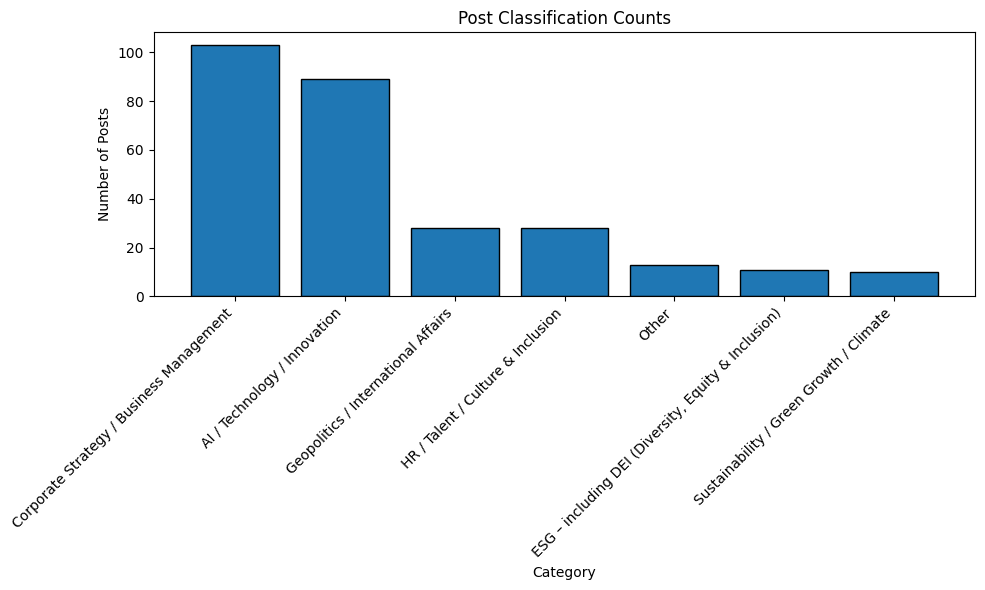

In [39]:
#visualise the results 

import matplotlib.pyplot as plt

# Count the categories
category_counts = df_ey_classified["ai_guess"].value_counts()

# Create bar chart manually for better alignment
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index, category_counts.values, edgecolor='black')

# Add labels and formatting
plt.title("Post Classification Counts")
plt.xlabel("Category")
plt.ylabel("Number of Posts")
plt.xticks(ticks=range(len(category_counts.index)), labels=category_counts.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()



<Figure size 1400x700 with 0 Axes>

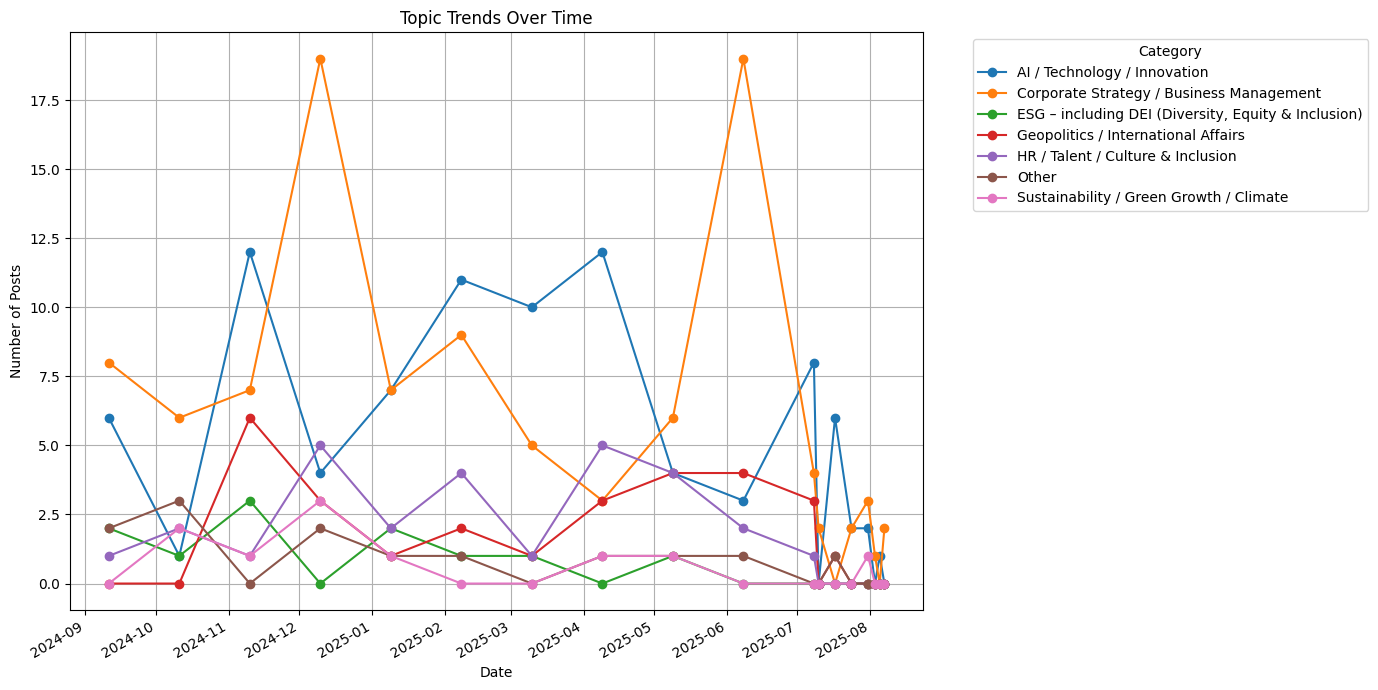

In [41]:
#trends over time 

import matplotlib.pyplot as plt

# Ensure normalized date is datetime
df_ey_classified["normalized_date"] = pd.to_datetime(df_ey_classified["normalized_date"])

# Group by date and category, then count
trend_data = df_ey_classified.groupby(["normalized_date", "ai_guess"]).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(14, 7))
trend_data.plot(kind='line', marker='o', figsize=(14, 7))

plt.title("Topic Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

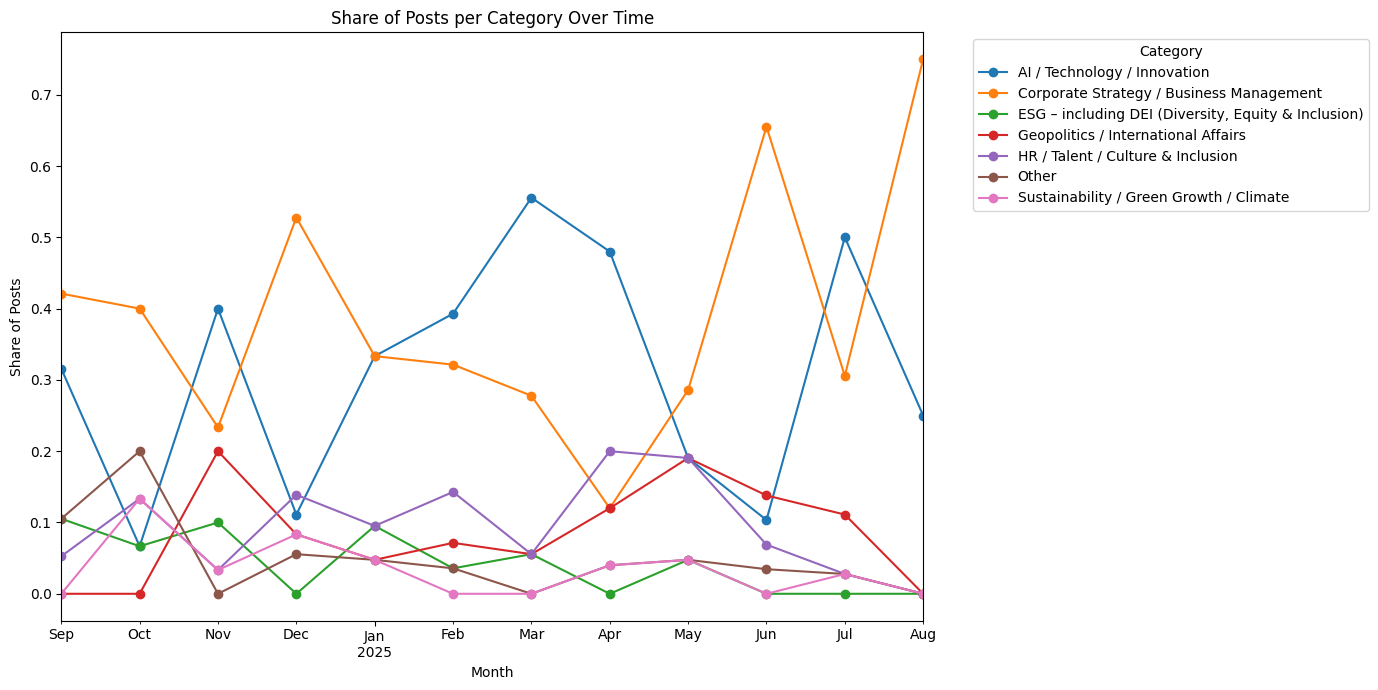

In [42]:
#what is the monthly share of posts in each category? 
df_ey_classified["month"] = df_ey_classified["normalized_date"].dt.to_period("M")

monthly_counts = df_ey_classified.groupby(["month", "ai_guess"]).size().unstack(fill_value=0)

monthly_shares = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

# Plot
monthly_shares.plot(figsize=(14, 7), marker='o')
plt.title("Share of Posts per Category Over Time")
plt.xlabel("Month")
plt.ylabel("Share of Posts")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [43]:
# monthly shares as percentages in table format 

df_ey_classified["month"] = df_ey_classified["normalized_date"].dt.to_period("M")

#Count posts by month and category
monthly_counts = df_ey_classified.groupby(["month", "ai_guess"]).size().unstack(fill_value=0)
monthly_total = monthly_counts.sum(axis=1)

#Calculate shares (in percentage)
monthly_shares_pct = monthly_counts.div(monthly_counts.sum(axis=1), axis=0) * 100
monthly_shares_pct = monthly_shares_pct.round(1)  # round to 1 decimal place
monthly_shares_pct["Total Posts"] = monthly_total

# Display as table
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)  # show all columns
display(monthly_shares_pct)

ai_guess,AI / Technology / Innovation,Corporate Strategy / Business Management,"ESG – including DEI (Diversity, Equity & Inclusion)",Geopolitics / International Affairs,HR / Talent / Culture & Inclusion,Other,Sustainability / Green Growth / Climate,Total Posts
month,,,,,,,,
2024-09,31.6,42.1,10.5,0.0,5.3,10.5,0.0,19
2024-10,6.7,40.0,6.7,0.0,13.3,20.0,13.3,15
2024-11,40.0,23.3,10.0,20.0,3.3,0.0,3.3,30
2024-12,11.1,52.8,0.0,8.3,13.9,5.6,8.3,36
2025-01,33.3,33.3,9.5,4.8,9.5,4.8,4.8,21
2025-02,39.3,32.1,3.6,7.1,14.3,3.6,0.0,28
2025-03,55.6,27.8,5.6,5.6,5.6,0.0,0.0,18
2025-04,48.0,12.0,0.0,12.0,20.0,4.0,4.0,25
2025-05,19.0,28.6,4.8,19.0,19.0,4.8,4.8,21


In [45]:
df_ey_classified["month"] = df_ey_classified["normalized_date"].dt.to_period("M")
df_ey_classified["month"].value_counts().sort_index()

month
2024-09    19
2024-10    15
2024-11    30
2024-12    36
2025-01    21
2025-02    28
2025-03    18
2025-04    25
2025-05    21
2025-06    29
2025-07    36
2025-08     4
Freq: M, Name: count, dtype: int64

In [46]:
#save as csv file 
df_ey_classified.to_csv("df_ey_classified.csv", index=False)
